# 1. Introduction
# COVID-19 has significantly impacted global health systems since its emergence in 2020. This analysis examines infection patterns and mortality trends using [...] 

In [2]:
# 1. Environment Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
pd.set_option('display.max_columns', 30)
print("Libraries loaded successfully.")

Libraries loaded successfully.


# 2. Problem Statement
# How can we identify high-risk regions and temporal patterns in COVID-19 progression to inform resource allocation and public health strategies?

In [3]:
# 2. Load Local Datasets
# Load your downloaded files
cases = pd.read_csv("time_series_covid19_confirmed_global.csv")
deaths = pd.read_csv("time_series_covid19_deaths_global.csv")

print(f"Cases data shape: {cases.shape}")
print(f"Deaths data shape: {deaths.shape}")
cases.head(2)

Cases data shape: (289, 1147)
Deaths data shape: (289, 1147)


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,...,2/23/23,2/24/23,2/25/23,2/26/23,2/27/23,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,...,209215,209230,209246,209274,209308,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,...,334345,334356,334373,334378,334380,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457


# 3. Key Questions

# 1. Which countries had the highest mortality rates?  
# 2. How did global cases/deaths evolve over time?  
# 3. Were there identifiable infection waves?  
# 4. Which regions were earliest/latest affected?  
# 5. How did mortality rates correlate with case volumes?

In [5]:
# 3. Data Preprocessing
# 3.1 Reshape Time Series Data
def reshape_data(df, value_name):
    """Convert wide-format time series to long format with proper datetime conversion"""
    return df.melt(
        id_vars=['Country/Region', 'Province/State', 'Lat', 'Long'],
        var_name='Date',
        value_name=value_name
    ).assign(Date=lambda x: pd.to_datetime(x['Date'], format='%m/%d/%y'))  # Explicit format for JHU data

# Process both datasets
cases_long = reshape_data(cases, 'Cases')
deaths_long = reshape_data(deaths, 'Deaths')

# Verify conversion
print("Cases data sample:")
display(cases_long.head())
print("\nDeaths data sample:")
display(deaths_long.head())

Cases data sample:


,Country/Region,Province/State,Lat,Long,Date,Cases
0,Afghanistan,NaN,33.93911,67.709953,2020-01-22,0
1,Albania,NaN,41.15330,20.168300,2020-01-22,0
2,Algeria,NaN,28.03390,1.659600,2020-01-22,0
3,Andorra,NaN,42.50630,1.521800,2020-01-22,0
4,Angola,NaN,-11.20270,17.873900,2020-01-22,0



Deaths data sample:


,Country/Region,Province/State,Lat,Long,Date,Deaths
0,Afghanistan,NaN,33.93911,67.709953,2020-01-22,0
1,Albania,NaN,41.15330,20.168300,2020-01-22,0
2,Algeria,NaN,28.03390,1.659600,2020-01-22,0
3,Andorra,NaN,42.50630,1.521800,2020-01-22,0
4,Angola,NaN,-11.20270,17.873900,2020-01-22,0


In [6]:
# 3.2 Merge Case/Death Data
covid_df = pd.merge(
    cases_long,
    deaths_long,
    on=['Country/Region', 'Province/State', 'Lat', 'Long', 'Date'],
    validate='one_to_one'
)

print(f"Merged data shape: {covid_df.shape}")
covid_df.sample(3)

Merged data shape: (330327, 7)


,Country/Region,Province/State,Lat,Long,Date,Cases,Deaths
278206,Monaco,NaN,43.7333,7.4167,2022-09-10,14436,63
303810,China,Hong Kong,22.3000,114.2000,2022-12-08,2203790,10891
254178,Iceland,NaN,64.9631,-19.0208,2022-06-19,191079,153


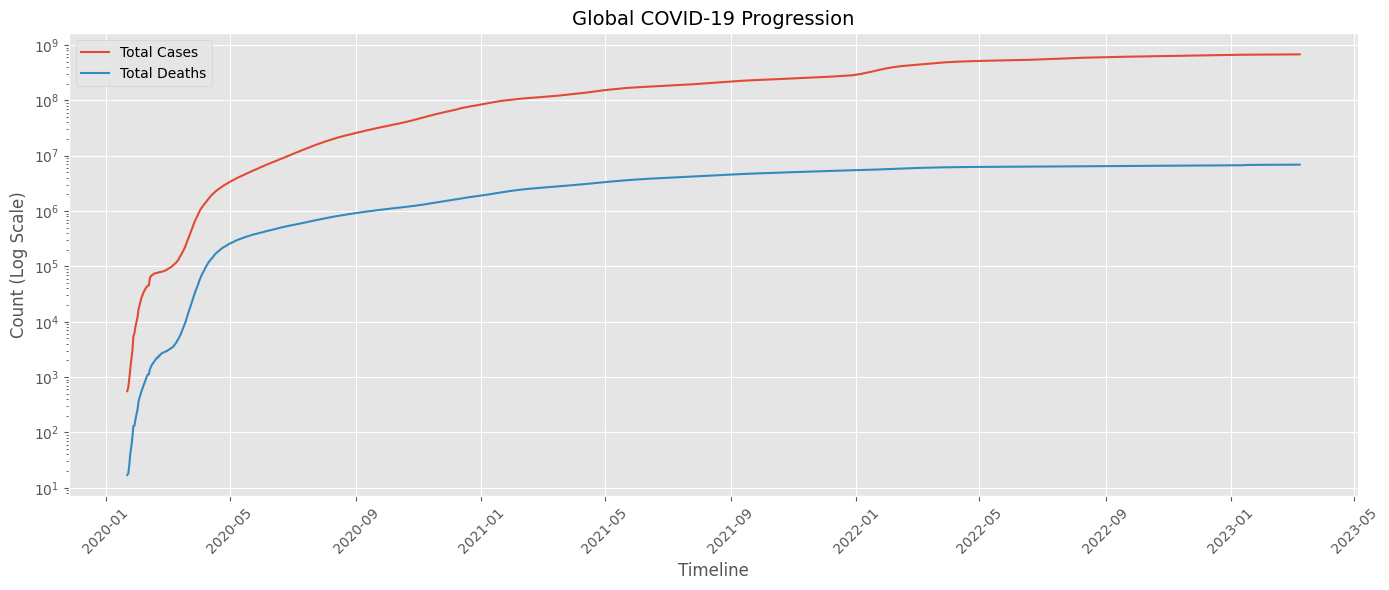

In [7]:
# 4. Core Analysis (Without Vaccination)
# 4.1 Global Infection Trends
global_trends = covid_df.groupby('Date').agg({'Cases':'sum', 'Deaths':'sum'})

plt.figure(figsize=(14,6))
plt.plot(global_trends.index, global_trends['Cases'], label='Total Cases')
plt.plot(global_trends.index, global_trends['Deaths'], label='Total Deaths')
plt.title('Global COVID-19 Progression', fontsize=14)
plt.xlabel('Timeline', fontsize=12)
plt.ylabel('Count (Log Scale)', fontsize=12)
plt.yscale('log')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

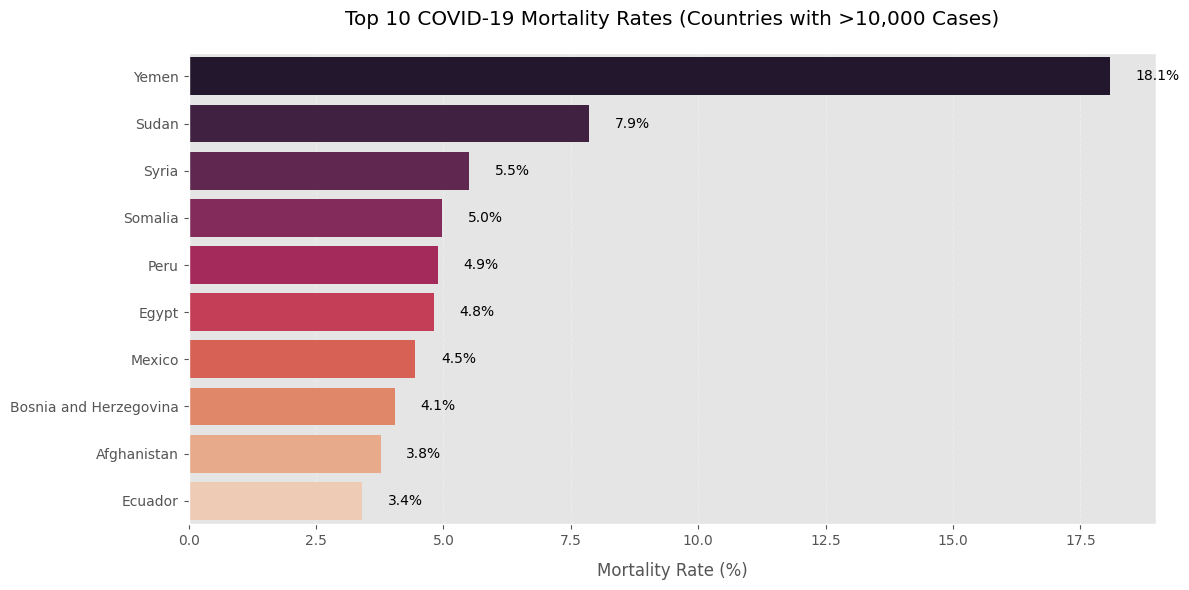


Detailed Statistics:


,Country/Region,Cases,Deaths,Mortality_Rate
198,Yemen,11945,2159,18.07%
169,Sudan,63829,5017,7.86%
174,Syria,57467,3164,5.51%
164,Somalia,27324,1361,4.98%
141,Peru,4487553,219539,4.89%
54,Egypt,515759,24812,4.81%
117,Mexico,7483444,333188,4.45%
22,Bosnia and Herzegovina,401729,16280,4.05%
0,Afghanistan,209451,7896,3.77%
53,Ecuador,1057121,36014,3.41%


In [9]:
# 4.2 Country-Level Mortality Analysis
# Calculate mortality rates for countries with significant case counts

# Get latest data snapshot
latest_data = covid_df[covid_df['Date'] == covid_df['Date'].max()]

# Aggregate by country
country_stats = latest_data.groupby('Country/Region', as_index=False).agg({
    'Cases': 'sum',
    'Deaths': 'sum'
}).query('Cases > 10000')  # Filter for meaningful analysis

# Calculate mortality rate (Deaths/Cases) with error handling
country_stats['Mortality_Rate'] = country_stats.apply(
    lambda x: (x['Deaths'] / x['Cases']) * 100 if x['Cases'] > 0 else 0, 
    axis=1
)

# Get top 10 highest mortality rates
top_mortality = country_stats.nlargest(10, 'Mortality_Rate')

# Create visualization
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=top_mortality,
    x='Mortality_Rate',
    y='Country/Region',
    hue='Country/Region',  # Explicit hue assignment
    palette='rocket',
    legend=False,  # Disable redundant legend
    dodge=False  # Single color per bar
)

# Formatting
ax.set_title('Top 10 COVID-19 Mortality Rates (Countries with >10,000 Cases)', pad=20)
ax.set_xlabel('Mortality Rate (%)', labelpad=10)
ax.set_ylabel('')
ax.xaxis.grid(True, linestyle='--', alpha=0.3)

# Annotate values
for i, (_, row) in enumerate(top_mortality.iterrows()):
    ax.text(row['Mortality_Rate'] + 0.5, i, 
            f"{row['Mortality_Rate']:.1f}%", 
            va='center')

plt.tight_layout()
plt.show()

# Display raw stats
print("\nDetailed Statistics:")
display(top_mortality[['Country/Region', 'Cases', 'Deaths', 'Mortality_Rate']]
       .style.format({'Mortality_Rate': '{:.2f}%'})
       .background_gradient(cmap='Reds', subset=['Mortality_Rate']))

In [10]:
# 5. Data Export
# Save processed data for reproducibility
covid_df.to_csv("processed_covid_data.csv", index=False)
print("Cleaned dataset exported successfully.")

Cleaned dataset exported successfully.
